In [4]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

In [5]:
expdir='/Volumes/ukps-all$/user/tdanko/Students/Gabriel/'
#master folder
protein="TNR"

In [6]:
results = {"filename":[],
           "ecmchannelno":[],"nucleichannelno":[],"synapsechannelno":[],
           "Manual mask from matlab GUI":[],
           "exp condition":[],"manual synapse spots mask":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if (protein in str(filelist[i]))==True:
            if ("TTX" in str(filelist[i]))==False:
                if filelist[i].endswith(".nd2"): 
                    results["filename"].append(filelist[i])
                    
                    results["exp condition"].append(filelist[i].split('/')[-2])
                    
                    channeldir="/".join(filelist[i].split("/")[:-2])
                    exec(open(channeldir+"/channels.txt").read())
                    results["ecmchannelno"].append(ecmchannelno)
                    results["nucleichannelno"].append(nucleichannelno)
                    results["synapsechannelno"].append(synapsechannelno)


## Loading a random image

Image name: 20181002_06_100x_004.nd2
Experimental condition: 4hrs_Bic


(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text yticklabel objects>)

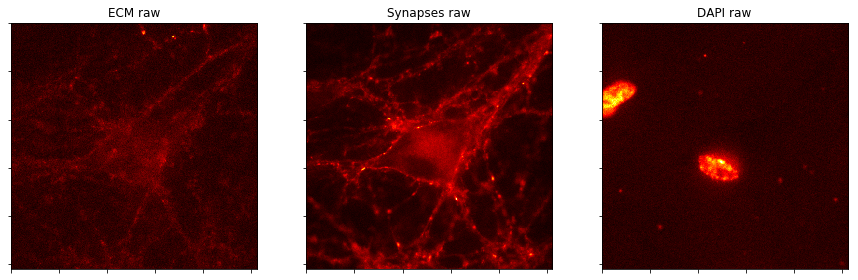

In [7]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]
with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    nuclei_image=images[nuclei_channel_no-1]
    synapse_image=images[synapse_channel_no-1]
    ###the part below just checks what filter was used in the microscope for the channels
    ###from the image metadata
    [channel1name, channel2name, channel3name]=ecm_image.metadata['channels']
    if ecm_channel_no==1:
        ecm_channelname=channel1name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel3name
        else:
            nuclei_channelname=channel3name
            synapse_channelname=channel2name
    if ecm_channel_no==2:
        ecm_channelname=channel2name
        if nuclei_channel_no==3:
            nuclei_channelname=channel3name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel3name
    if ecm_channel_no==3:
        ecm_channelname=channel3name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel2name
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(132)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(133)
plt.imshow(nuclei_image,interpolation='none',cmap='hot')
plt.title('DAPI raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)

## Find spots

### Manual

In [8]:
#make empty masks
for i in range(0,len(results["filename"])):
    results["manual synapse spots mask"].append(np.nan)

### Make masks

In [9]:
import ipywidgets as widgets
from ipywidgets import interact
first=0

#load first image
syt1_image_name=results["filename"][first]

synapse_channel_no=results["synapsechannelno"][first]

with ND2Reader(syt1_image_name) as images:
    syt1_image=images[synapse_channel_no-1]

syt1_spots=deepcopy(syt1_image)
syt1_spots=ndi.median_filter(syt1_spots,size=5)

lower_man_threshold=np.min(syt1_spots)
upper_man_threshold=np.max(syt1_spots)

def f(Threshold,Manual_Threshold,Open,Close,Image_no):
    
    ii=Image_no
    
    syt1_image_name=results["filename"][ii]
    synapse_channel_no=results["synapsechannelno"][ii]

    with ND2Reader(syt1_image_name) as images:
        syt1_image=images[synapse_channel_no-1]
    
    syt1_spots=deepcopy(syt1_image)
    lower_man_threshold=np.min(syt1_spots)
    upper_man_threshold=np.max(syt1_spots)

    if Threshold=="Li":
        syt1_image_threshold=threshold_li(syt1_image)      
    if Threshold=="Otsu":
        syt1_image_threshold=threshold_otsu(syt1_image)
    if Threshold=="Manual":
        syt1_image_threshold=Manual_Threshold
    
    syt1_spots[syt1_spots<syt1_image_threshold]=0
    syt1_spots=ndi.binary_opening(syt1_spots,iterations=Open)
    syt1_spots=ndi.binary_closing(syt1_spots,iterations=Close)
    results["manual synapse spots mask"][ii]=syt1_spots
    fig=plt.figure(figsize=(20,20))
    fig.add_subplot(121)
    plt.imshow(syt1_spots)
    plt.imshow(syt1_image,alpha=0.5,cmap='inferno')
    fig.add_subplot(122)
    plt.imshow(syt1_image,cmap='inferno')
    

#widgets
Threshold=widgets.Dropdown(options=["Li","Otsu","Manual"])
Manual_Threshold=widgets.IntSlider(min=lower_man_threshold,max=upper_man_threshold,step=1,value=lower_man_threshold)
Open=widgets.IntText(min=0,max=20,step=1,value=1)
Close=widgets.IntText(min=0,max=20,step=1,value=1)
Image_no=widgets.IntText(min=0,max=len(results["filename"]),value=0)

w=interact(f,Threshold=Threshold,Manual_Threshold=Manual_Threshold,Open=Open,Close=Close,
           Image_no=Image_no)

interactive(children=(Dropdown(description='Threshold', options=('Li', 'Otsu', 'Manual'), value='Li'), IntSlid…

### Back up the syt masks

In [11]:
for image in range(0,len(results_syt1["filename"])):
    np.save(results_syt1["filename"][image]+'_syt_spots_mask_conservative.npy',results_syt1["Manual syt spots mask"][image])